
# Bankruptcy Predictions

<hr>

## Table of Contents
1. [Introduction](#intro)
<br> 1.1 [Import Libraries](#implibs)
2. [Dataset Exploration](#dataexp)
<br> 2.1 [Missing Values in Datasets](#missing)
<br> 2.2 [Data Imputation](#imputation)
<br> 2.3 [Imbalanced Data](#imbalanced)
<br> 2.4 [SMOTE](#smote)
3. [Feature Exploration](#featexp)
<br> 3.1 [Feature Magnitude](#featrange)
<br> 3.2 [Feature Distributions](#featdist)
4. [Dimensionality Reduction and Feature Selection](#featredsel)
<br> 4.1 [Principal Component Analysis (PCA)](#pca)
<br> 4.2 [Chi2 Feature Selection](#chi2)
<br> 4.3 [RFE using Logistic Regression](#rfe)
5. [Data Modeling and Classification](#modeling)
<br> 5.1 [Machine Learning Techniques](#mlmodels)
<br> - 5.1.1 [Decision Tree (CART)](#dt)
<br> - 5.1.2 [Random Forest](#randomforest)
<br> - 5.1.3 [Logistic Regression](#logisticregression)
<br> 5.2 [Experiments](#exps)
<br> - 5.2.1 [Experiment 1 - Imputed Oversampled Datasets](#exp1)
<br> - 5.2.2 [Experiment 2 - Feature Reduction (PCA) Datasets](#exp2)
<br> - 5.2.3 [Experiment 3 - Feature Selection (Chi2) Datasets](#exp3)
<br> - 5.2.4 [Experiment 4 - Feature Selection (RFE) Datasets](#exp4)
<br> 5.3 [Perform Data Modeling Third Party Library (sklearn)](#sklearn)
<br> - 5.3.1 [Experiment 1 - Imputed Oversampled Datasets (sklearn)](#sklearnexp1)
<br> - 5.3.2 [Experiment 2 - Feature Reduction (PCA) Datasets (sklearn)](#sklearnexp2)
<br> - 5.3.3 [Experiment 3 - Feature Selection (Chi2) Datasets (sklearn)](#sklearnexp3)
<br> - 5.3.4 [Experiment 4 - Feature Selection (RFE) Datasets (sklearn)](#sklearnexp4)
6. [Results from Experiments](#results)
<br> 6.1 [Ranking Machine Learning Techniques](#rank)
7. [Conclusion](#conclusion)
8. [References](#references)

<a id="intro"></a>
## 1. Introduction

The dataset chosen for this project is about bankrupt Polish companies [1] that were analysed between
2000 and 2012, while the non-bankrupt companies were investigated between 2007 to 2013. The data was
acquired from EMIS [2] which is a service that offers information on emerging markets. Furthermore, this
dataset will be used to classify and predict whether Polish companies will go bankrupt or not.

• <b>1st year:</b> contains financial rates from 1st year of the forecasting period and corresponding
class label that indicates bankruptcy status after 5 years.

• <b>2nd year:</b> contains financial rates from 2nd year of the forecasting period and corresponding
class label that indicates bankruptcy status after 4 years.

• <b>3rd year:</b> contains financial rates from 3rd year of the forecasting period and corresponding
class label that indicates bankruptcy status after 3 years.

• <b>4th year:</b> contains financial rates from 4th year of the forecasting period and corresponding
class label that indicates bankruptcy status after 2 years.

• <b>5th year:</b> contains financial rates from 5th year of the forecasting period and corresponding
class label that indicates bankruptcy status after 1 year.

<a id="implibs"></a>
### 1.1 Import Libraries

In [1]:
# importing libraries 
import warnings
warnings.filterwarnings("ignore")

# to time experiments
import time
# for arrays and data handling
import numpy as np
import pandas as pd

# to calculate kurtosis and skew
from scipy.stats import kurtosis
from scipy.stats import skew

# for plots
import seaborn as sns 
import matplotlib as pl
import matplotlib.pyplot as plt

import dataexp as dtex # our code
import dataio as dtio # our code 
import preprocessing as pre # our code

# to display pandas and other elements in html
from IPython.display import display
from IPython.core.display import HTML
from IPython.display import Image

# for ordered dictionaries 
from collections import OrderedDict

# for feature extraction
import feature_extraction as fe # our code

# machine learning models/techniques
import model_validation as me # our code

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as sklm

# for final validation to plot ROC curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from itertools import cycle

%matplotlib inline

Using TensorFlow backend.


<a id="dataexp"></a>
## 2. Dataset Exploration

In [2]:
# # show the features found in the dataset
# print("The different features, image taken from [3]")
# display(Image("imgs/features.JPG"))

In [3]:
# importing data 
path = "data/"
extensions = ".arff"

# get files with .arff extension in path specified
files_path = dtio.file_paths(path, extensions)
# converts .arff files to dataframes 
df_years = dtio.arff2df(files_path, True) 

# create column names 
columns_name = []
for i in range(df_years[0][1].shape[1] - 1):
    columns_name.append("x" + str(i + 1))
columns_name.append("outcome")

# change header/column names 
# convert features to floats (to make sure we have consistency)
# changing the class/outcome column to 0 and 1 (not bankrupt and bankrupt)
# print path and shape for each dataframe imported & convert outcome variable to 0/1
def format_dict_dfs(dict_dfs, col_names, verbose = False):
    for i in range(len(dict_dfs)):
        dict_dfs[i][1].columns = col_names 
        dict_dfs[i][1][col_names[:-1]] = dict_dfs[i][1][col_names[:-1]].apply(pd.to_numeric)
        dict_dfs[i][1]["outcome"] = dict_dfs[i][1]["outcome"].astype("category").cat.codes

        if(verbose == True):
            print("Path: {0}, Shape: {1}".format(dict_dfs[i][0], dict_dfs[i][1].shape))

# format dataframes
format_dict_dfs(df_years, columns_name, True)
            
# since we made sure which dataframe was loaded from (path) and sorted by year 
# make list of different dataframes 
dataframes = [x[1] for x in df_years]

# print head for first case (year 1)
display(dataframes[0].head())
#display(year_one.dtypes)

Path: data/1year.arff, Shape: (7027, 65)
Path: data/2year.arff, Shape: (10173, 65)
Path: data/3year.arff, Shape: (10503, 65)
Path: data/4year.arff, Shape: (9792, 65)
Path: data/5year.arff, Shape: (5910, 65)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x56,x57,x58,x59,x60,x61,x62,x63,x64,outcome
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


<a id="missing"></a>
### 2.1 Missing Values in Datasets

• <b>Nullity Matrix:</b> Used to find patterns visually for missing values. White space means missing values for the specific feature.

• <b>Nullity Correaltion Heatmap:</b> Measures the nullity correlation between the features. If a value of 1 is shown in the box, it means that if one feature is missing the other is also missing. On the other hand if -1 is shown it means if one feature is missing the other is not. The output can be a value between -1 to 1 and if the value is to small (-0.05 < V < 0.05), nothing is shown.

,year,total_instances,total_instances_with_missing_values,total_instances_without_missing_values,data_loss
0,1_year,7027.0,3833.0,3194.0,0.5455
1,2_year,10173.0,6085.0,4088.0,0.5982
2,3_year,10503.0,5618.0,4885.0,0.5349
3,4_year,9792.0,5023.0,4769.0,0.5130
4,5_year,5910.0,2879.0,3031.0,0.4871


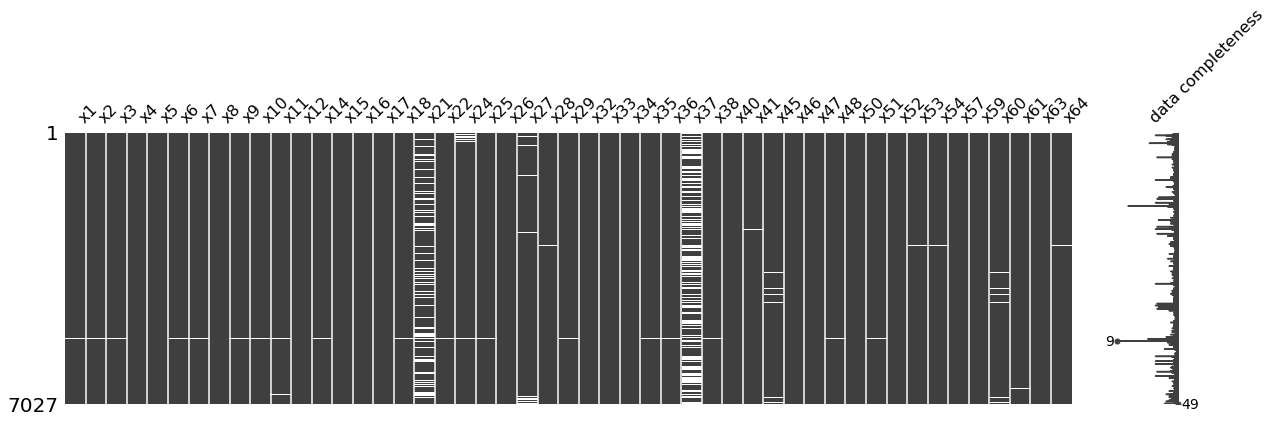

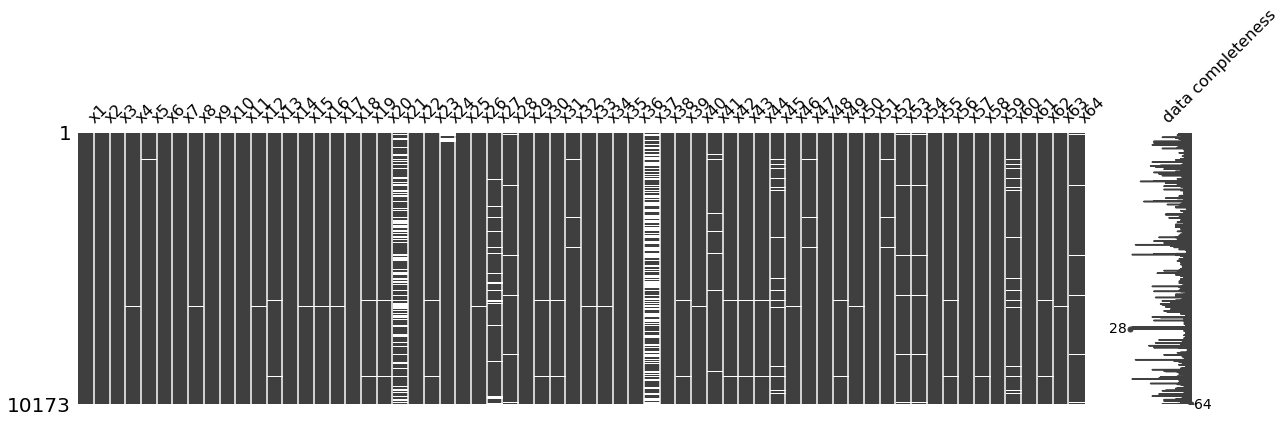

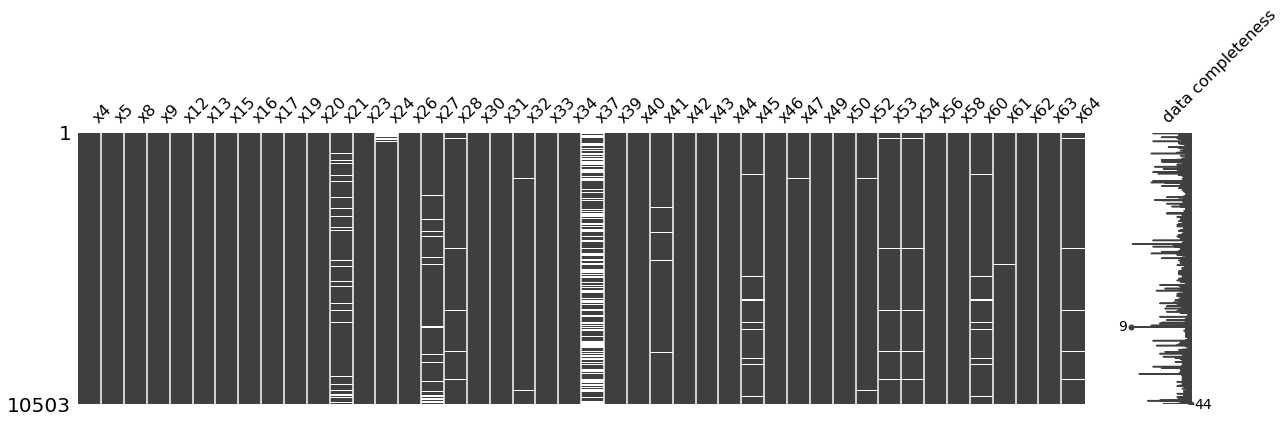

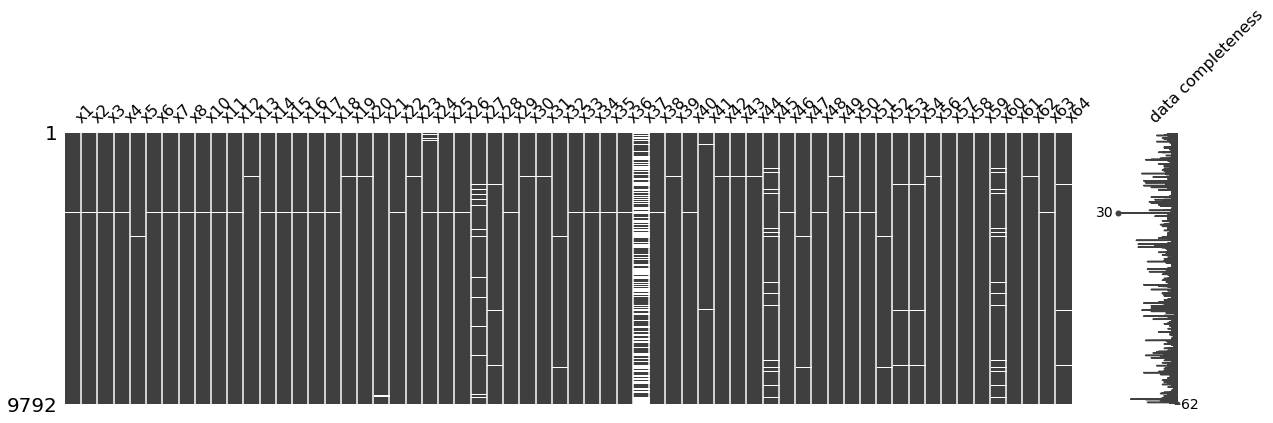

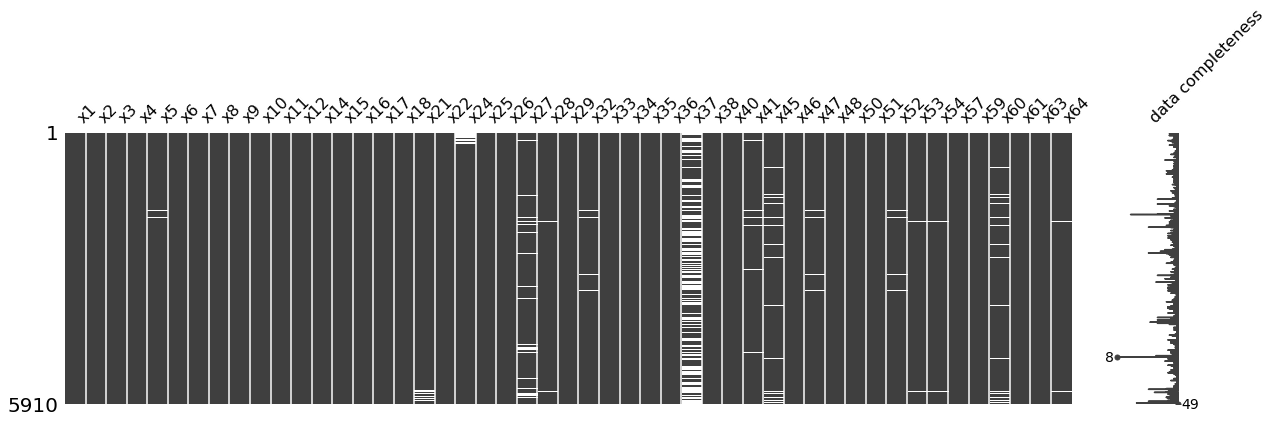

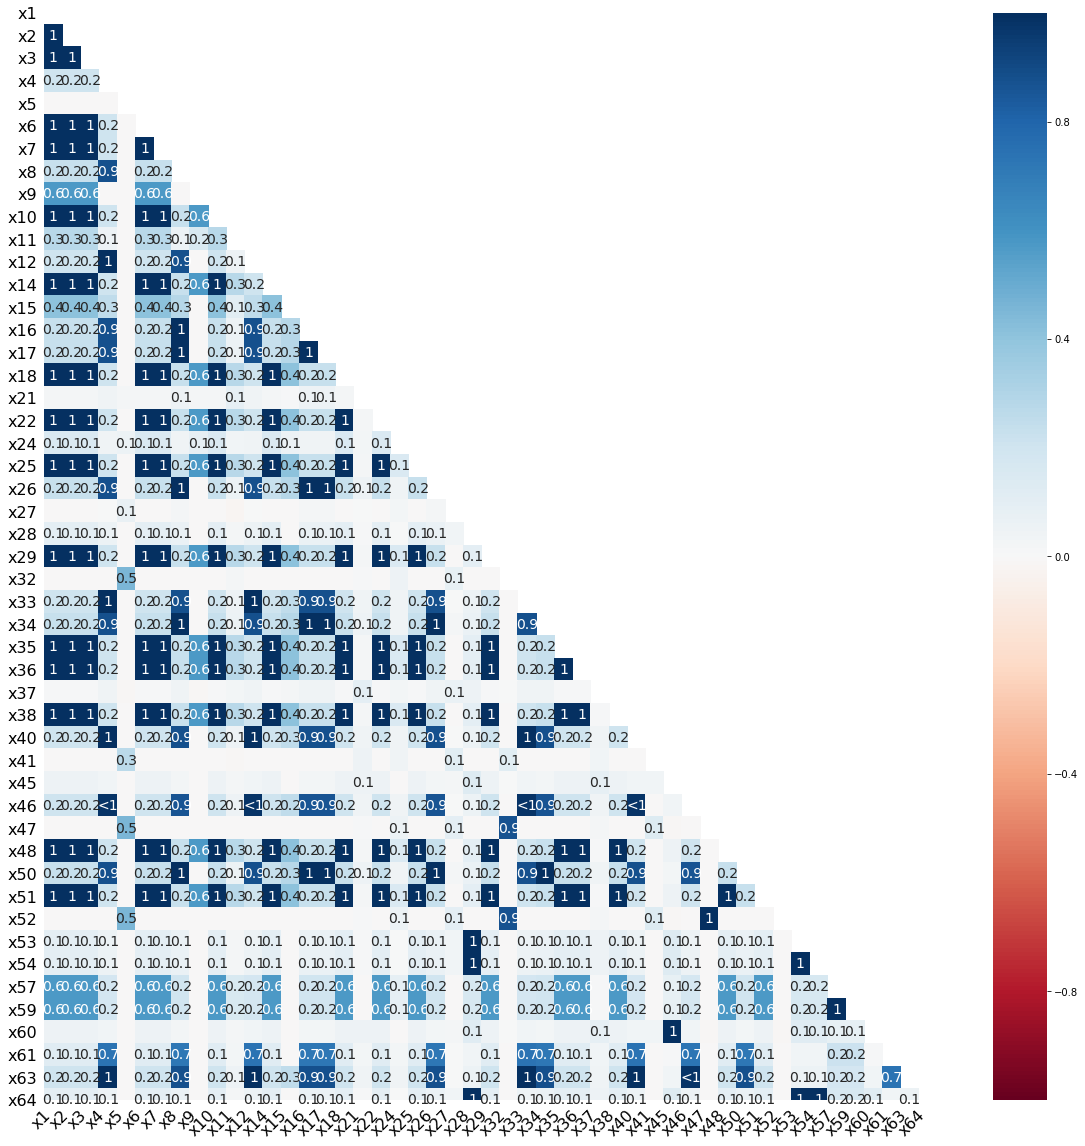

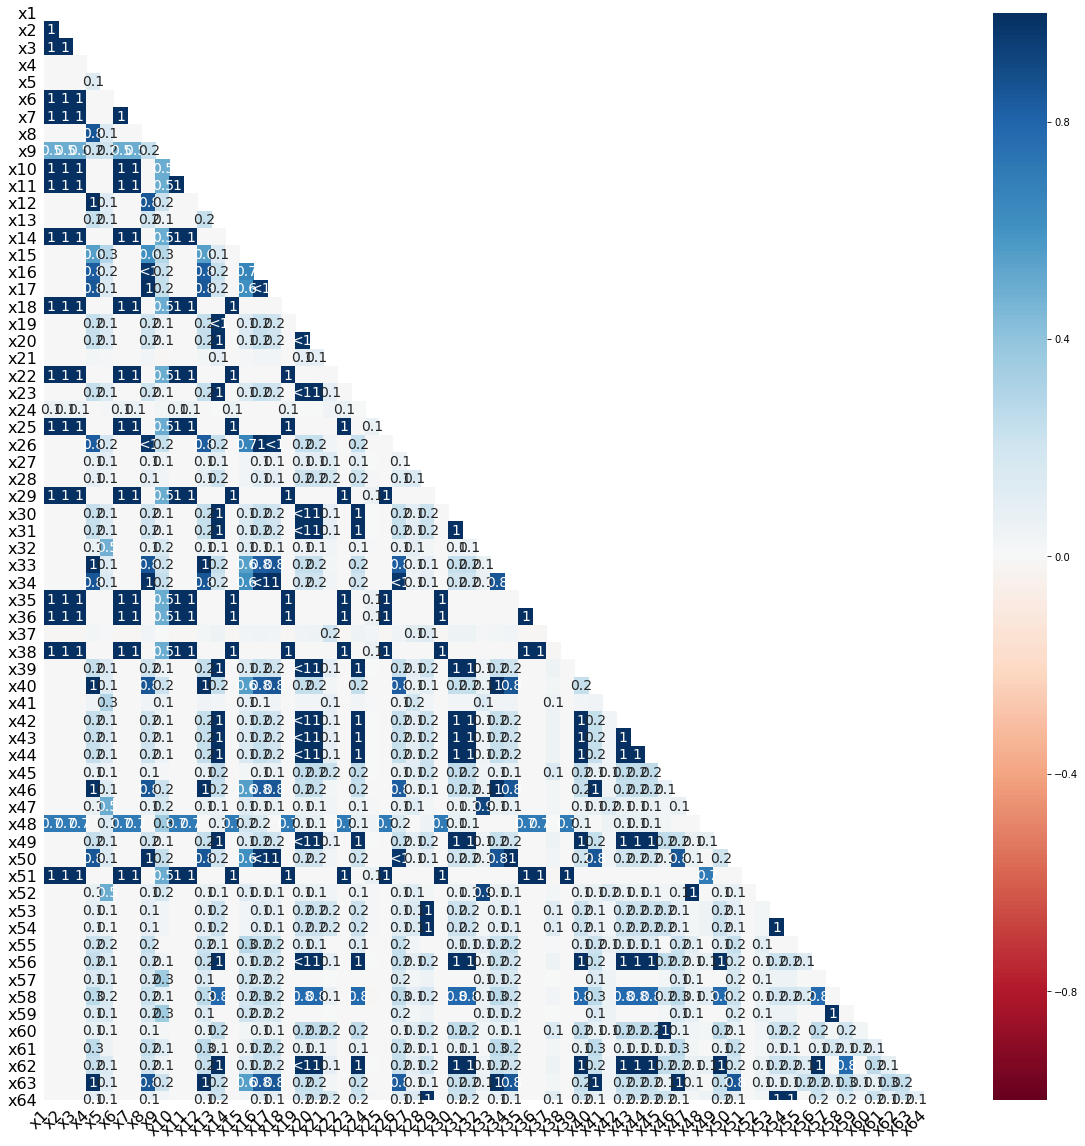

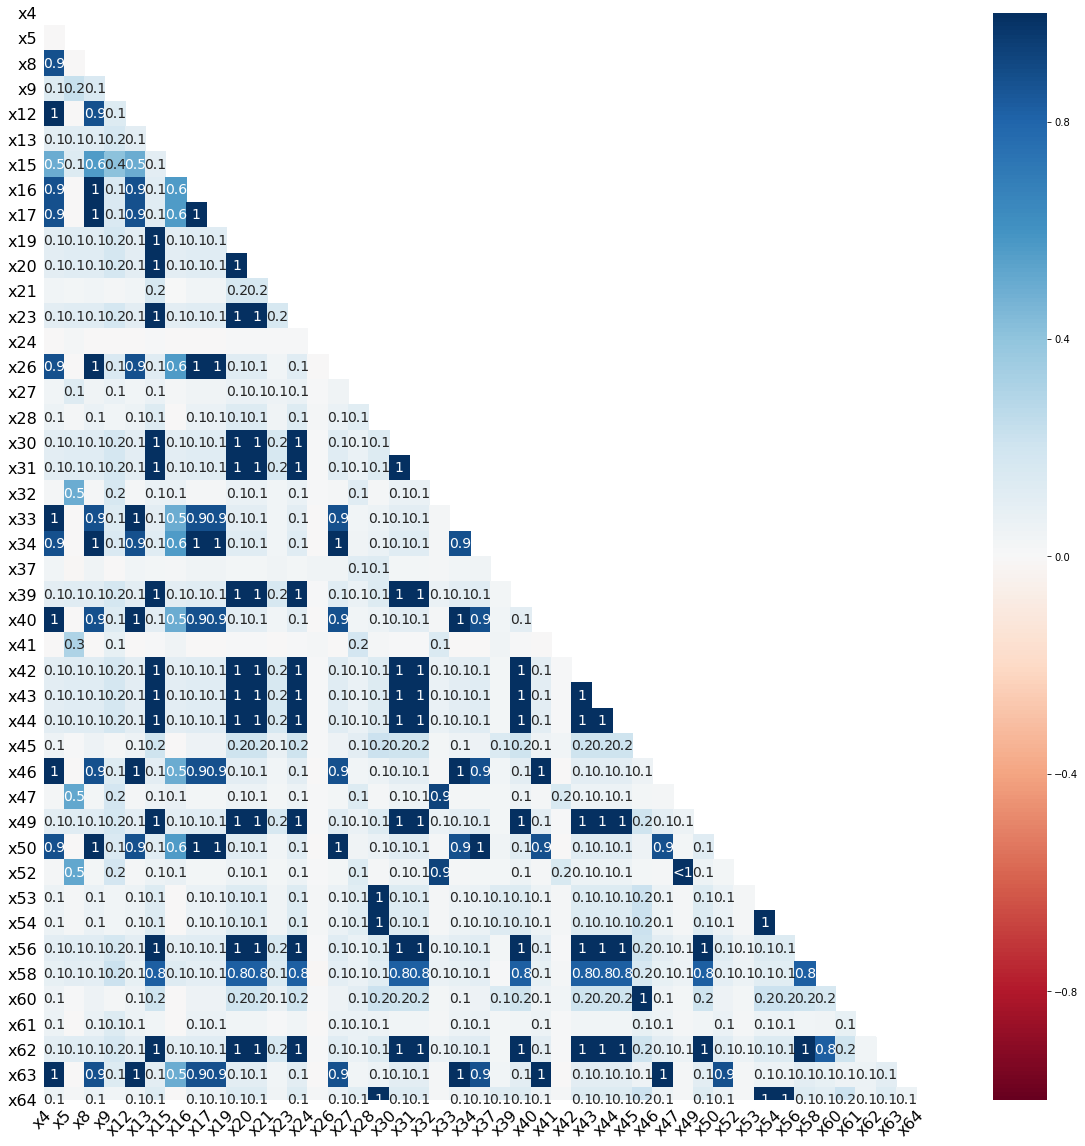

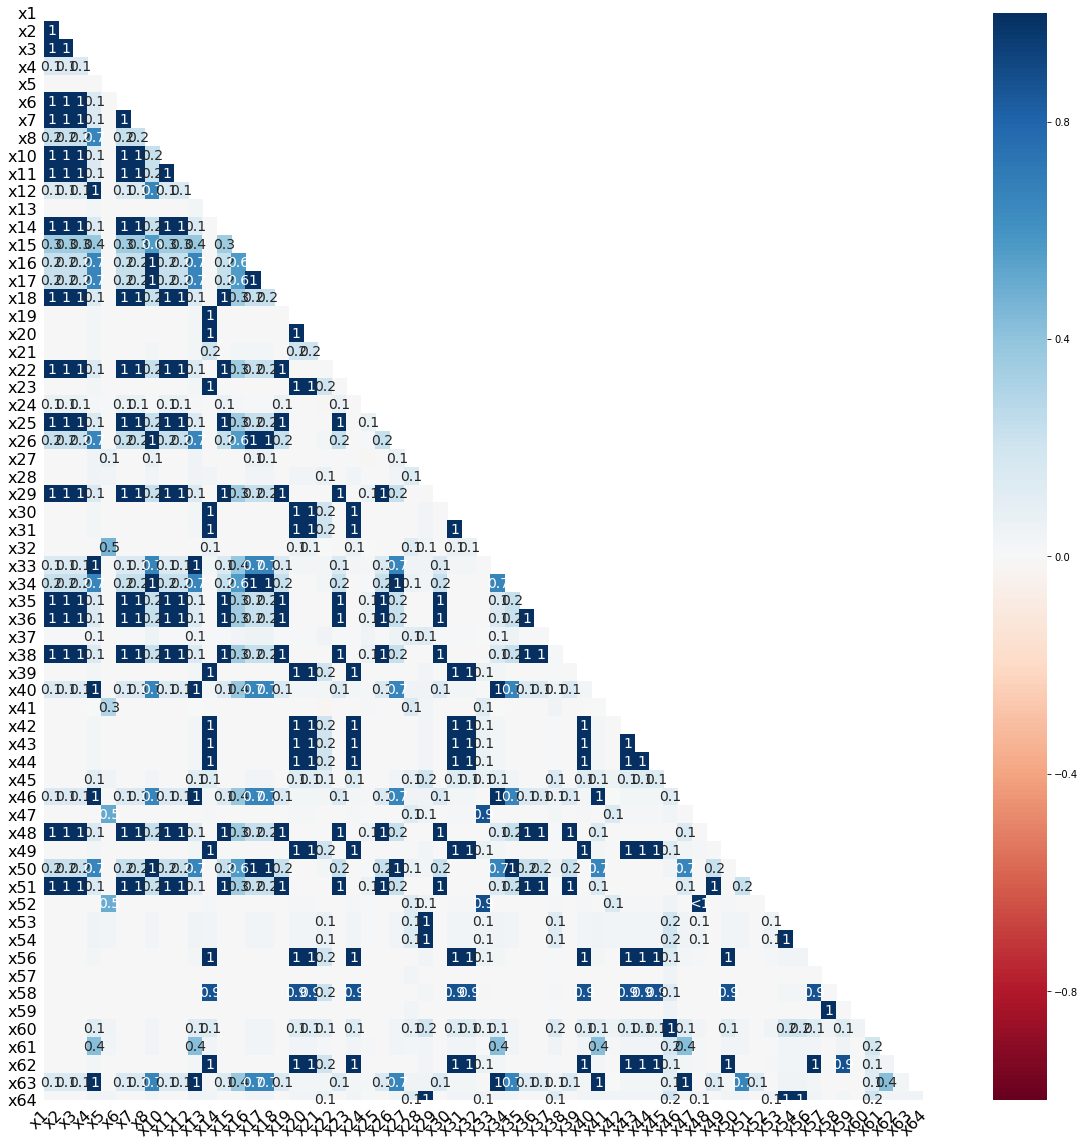

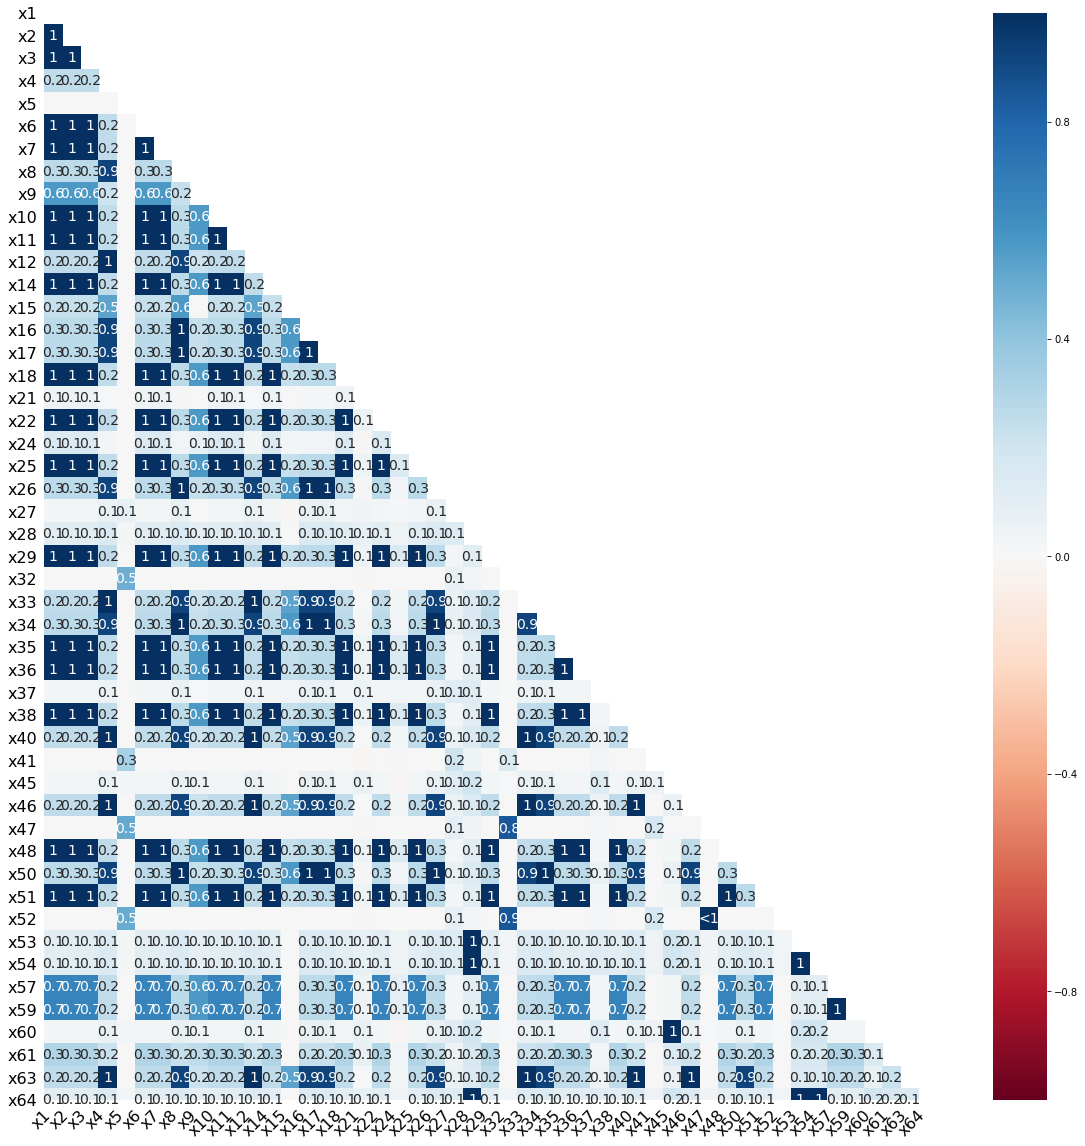

In [4]:
# displaying missing values stats
missing_stats_df = dtex.missing_stats(dataframes)
year_headers = ["1_year" , "2_year", "3_year" , "4_year", "5_year"]
missing_stats_df.insert(loc=0, column= "year", value= year_headers)
display(missing_stats_df)

# nullity matrix 
dtex.nullity_matrix(dataframes, include_all = False)
# heatmap - nullity correlation 
dtex.nullity_heatmap(dataframes, include_all = False)

<a id="imputation"></a>
### 2.2 Data Imputation 

• <b>Mean Imputation:</b> This technique imputes the missing data with the mean of that feature, where the
data can only be numeric. Due to the nature of all the missing data being imputed with the same value,
it sometimes has the undesirable effect of adding bias and reducing variance, which in turn affects the
correlation value between other features.

• <b>Mode Imputation:</b> This technique imputes the missing data with the most frequent value for that
feature, with the intuition that the modal value has a higher chance of being in the dataset. The
advantage of this technique is that it can also be used on non-numeric data.

In [5]:
# save imputation data if files dont exists + retrieve
imp_common_path = path + "imputation"

# mean imputation
imp_mean_path = imp_common_path + "_mean/"
dtio.df2arff_function(imp_mean_path, year_headers, pre.mean_imputation, dataframes)
imp_mean_dfs = dtio.arff2df(dtio.file_paths(imp_mean_path, extensions), True)  
format_dict_dfs(imp_mean_dfs, columns_name, True)

# # median imputation
# imp_median_path = imp_common_path + "_median/"
# dtio.df2arff_function(imp_median_path, year_headers, pre.median_imputation, dataframes)
# imp_median_dfs = dtio.arff2df(dtio.file_paths(imp_median_path, extensions), True)  
# format_dict_dfs(imp_median_dfs, columns_name, True)

# mode imputation 
imp_mode_path = imp_common_path + "_mode/"
dtio.df2arff_function(imp_mode_path, year_headers, pre.mode_imputation, dataframes)
imp_mode_dfs = dtio.arff2df(dtio.file_paths(imp_mode_path, extensions), True)  
format_dict_dfs(imp_mode_dfs, columns_name, True)

# expectation maximization imputation
imp_em_path = imp_common_path + "_em/"
dtio.df2arff_function(imp_em_path, year_headers, pre.em_imputation, dataframes, "float", 60)
imp_em_dfs = dtio.arff2df(dtio.file_paths(imp_em_path, extensions), True)  
format_dict_dfs(imp_em_dfs, columns_name, True)

# multivariate imputation by chained equations imputation
imp_mice_path = imp_common_path + "_mice/"
dtio.df2arff_function(imp_mice_path, year_headers, pre.mice_imputation, dataframes, "float")
imp_mice_dfs = dtio.arff2df(dtio.file_paths(imp_mice_path, extensions), True)  
format_dict_dfs(imp_mice_dfs, columns_name, True)

# k nearest neighbours imputation
imp_knn_path = imp_common_path + "_knn/"
dtio.df2arff_function(imp_knn_path, year_headers, pre.knn_imputation, dataframes, "float", 100)
imp_knn_dfs = dtio.arff2df(dtio.file_paths(imp_knn_path, extensions), True)
format_dict_dfs(imp_knn_dfs, columns_name, True)

# creating ordered dictionary for all different imputation methods 
imp_dfs_dict = OrderedDict()
# imp_dfs_dict["Mean"] = [x[1] for x in imp_mean_dfs]
# imp_dfs_dict["Median"] = [x[1] for x in imp_median_dfs]
# imp_dfs_dict["Mode"] = [x[1] for x in imp_mode_dfs]
imp_dfs_dict["Em"] = [x[1] for x in imp_em_dfs]
imp_dfs_dict["Knn"] = [x[1] for x in imp_knn_dfs]
imp_dfs_dict["Mice"] = [x[1] for x in imp_mice_dfs]

Path: data/imputation_mean/1_year.arff, Shape: (7027, 65)
Path: data/imputation_mean/2_year.arff, Shape: (10173, 65)
Path: data/imputation_mean/3_year.arff, Shape: (10503, 65)
Path: data/imputation_mean/4_year.arff, Shape: (9792, 65)
Path: data/imputation_mean/5_year.arff, Shape: (5910, 65)
Path: data/imputation_mode/1_year.arff, Shape: (7027, 65)
Path: data/imputation_mode/2_year.arff, Shape: (10173, 65)
Path: data/imputation_mode/3_year.arff, Shape: (10503, 65)
Path: data/imputation_mode/4_year.arff, Shape: (9792, 65)
Path: data/imputation_mode/5_year.arff, Shape: (5910, 65)
Path: data/imputation_em/1_year.arff, Shape: (7027, 65)
Path: data/imputation_em/2_year.arff, Shape: (10173, 65)
Path: data/imputation_em/3_year.arff, Shape: (10503, 65)
Path: data/imputation_em/4_year.arff, Shape: (9792, 65)
Path: data/imputation_em/5_year.arff, Shape: (5910, 65)
Path: data/imputation_mice/1_year.arff, Shape: (7027, 65)
Path: data/imputation_mice/2_year.arff, Shape: (10173, 65)
Path: data/imputa

<a id="imbalanced"></a>
### 2.3 Imbalanced Data 

In [6]:
imbalanced_stats_df = dtex.imbalanced_stats(dataframes, 'outcome')
imbalanced_stats_df.insert(loc=0, column= "year", value= year_headers)
display(imbalanced_stats_df)

,year,label_0,label_1,minortiy_label,minority_percentage
0,1_year,6756.0,271.0,1.0,0.038566
1,2_year,9773.0,400.0,1.0,0.039320
2,3_year,10008.0,495.0,1.0,0.047129
3,4_year,9277.0,515.0,1.0,0.052594
4,5_year,5500.0,410.0,1.0,0.069374


<a id="smote"></a>
### 2.4 Oversampling Datasets using synthetic minority over-sampling technique (SMOTE)

SMOTE or Synthetic Minority Over-sampling Technique [4] works by selecting/sampling similar instances
of the minority class, by finding the nearest neighbours k (using some distance metric based on the feature
set) and changing each attribute one at time by multiplying each x by a random number (between 0 to 1),
therefore creating a new synthetic instance.

In [30]:
os_dfs_dict=imp_dfs_dict
print(os_dfs_dict)

OrderedDict([('Em', [            x1        x2        x3         x4        x5        x6        x7  \
0     0.200550  0.379510  0.396410    2.04720   32.3510  0.388250  0.249760   
1     0.209120  0.499880  0.472250    1.94470   14.7860  0.000000  0.258340   
2     0.248660  0.695920  0.267130    1.55480   -1.1523  0.000000  0.309060   
3     0.081483  0.307340  0.458790    2.49280   51.9520  0.149880  0.092704   
4     0.187320  0.613230  0.229600    1.40630   -7.3128  0.187320  0.187320   
5     0.228220  0.497940  0.359690    1.75020  -47.7170  0.000000  0.281390   
6     0.111090  0.647440  0.289710    1.47050    2.5349  0.000000  0.111090   
7     0.532320  0.027059  0.705540   53.95400  299.5800  0.000000  0.652400   
8     0.009020  0.632020  0.053735    1.12630  -37.8420  0.000000  0.014434   
9     0.124080  0.838370  0.142040    1.16940  -91.8830  0.000000  0.153280   
10    0.240010  0.443550  0.188350    1.44000  -21.1650 -0.931900  0.240010   
11   -0.027117  0.111480  0.119

In [10]:
# creating ordered dictionary for all different oversampled imputation methods 
os_dfs_dict = OrderedDict()

# apply smote and add to dictionary
for key in imp_dfs_dict:
    print("Imputation Method: " + key)
    os_dfs_dict[key] = pre.oversample_smote(imp_dfs_dict[key], columns = columns_name,  verbose = True)
    print("#######################################################################\n")

Imputation Method: Em
original dataset (labels): {0: 6756, 1: 271}
total: 7027
resampled dataset (labels): {0: 338, 1: 271}
total: 609

original dataset (labels): {0: 9773, 1: 400}
total: 10173
resampled dataset (labels): {0: 500, 1: 400}
total: 900

original dataset (labels): {0: 10008, 1: 495}
total: 10503
resampled dataset (labels): {0: 618, 1: 495}
total: 1113

original dataset (labels): {0: 9277, 1: 515}
total: 9792
resampled dataset (labels): {0: 643, 1: 515}
total: 1158

original dataset (labels): {0: 5500, 1: 410}
total: 5910
resampled dataset (labels): {0: 512, 1: 410}
total: 922

#######################################################################

Imputation Method: Knn
original dataset (labels): {0: 6756, 1: 271}
total: 7027
resampled dataset (labels): {0: 338, 1: 271}
total: 609

original dataset (labels): {0: 9773, 1: 400}
total: 10173
resampled dataset (labels): {0: 500, 1: 400}
total: 900

original dataset (labels): {0: 10008, 1: 495}
total: 10503
resampled dataset (

<a id="featexp"></a>
## 3. Feature Exploration

<a id="featrange"></a>
### 3.1 Feature Magnitude (ranges)

In [ ]:
def multi_dataframes(table_list):
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>')

# display various ranges 
pd.options.display.float_format = '{:.4f}'.format
for i in range(len(dataframes)):    
    range_tables = []
    describe = pd.DataFrame(dataframes[i].describe().T)
    describe = describe.drop(describe.index[len(describe)-1])

    for g, tmp_df in describe.groupby(np.arange(len(describe)) // 32):
        range_tables.append(tmp_df[["min","max","mean"]])
#         print(range_tables)
#         break
    
    print(year_headers[i])
    display(multi_dataframes(range_tables))
#     df1 = (range_tables)
#     df1.to_excel("dataRange.xlsx",sheet_name=year_headers[i])  
#     print(range_tables)

<a id="featdist"></a>
### 3.2 Feature Distributions

In [ ]:
# import cufflinks as cf
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
# for i in range(len(dataframes)):    
#     print(year_headers[i])
#     sns.pairplot(dataframes[i])
# #     print(sns.heatmap(dataframes[i].corr()))
# #     print(year_headers[0])
# # print(sns.heatmap(dataframes[0].corr()))
# #     dataframes[i].corr().iplot(kind='heatmap',colorscale="YlOrRd",title="Feature Correlation for Year{0}".format(i+1))
# # help(dataframs[0].iplot)

In [ ]:
# import cufflinks as cf
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
# for i in range(len(dataframes)):    
#     print(year_headers[i])
# #     print(sns.heatmap(dataframes[i].corr()))
# #     print(year_headers[0])
# # print(sns.heatmap(dataframes[0].corr()))
#     dataframes[i].corr().iplot(kind='heatmap',colorscale="YlOrRd",title="Feature Correlation for Year{0}".format(i+1))
# # help(dataframs[0].iplot)

In [ ]:
# plot_col = 4
# plot_rows = int((dataframes[0].shape[1] - 1) / 4)

# # creates subplot for feature distributions + stats
# def plot_dist_df(df,name):
#     tmp_drop = df.dropna()
#     fig, ax = plt.subplots(plot_rows, plot_col, sharex= False, sharey= False, figsize=(12, 75))    
#     for j in range(plot_col * plot_rows):
#         column_name = columns_name[j]
#         row_index = int(j / plot_col) 
#         col_index = j % plot_col
        
#         feature = np.array(tmp_drop[column_name].values)
#         tmp_ax = ax[row_index][col_index]
#         tmp_ax.set_title(column_name)
        
#         mean_txt = "Mean:{0}".format(round(feature.mean(), 4))
#         tmp_ax.text(0.5,-0.12, mean_txt , size=11, ha="center", transform=tmp_ax.transAxes)
        
#         var_txt = "STD:{0}".format(round(feature.std(), 4))
#         tmp_ax.text(0.5,-0.22, var_txt , size=11, ha="center", transform=tmp_ax.transAxes)

#         skew_text = "Skew:{0}".format(round(skew(feature), 4))
#         tmp_ax.text(0.5,-0.32, skew_text , size=11, ha="center", transform=tmp_ax.transAxes)
        
#         kurtosis_txt = "Kurtosis:{0}".format(round(kurtosis(feature), 4))
#         tmp_ax.text(0.5,-.42, kurtosis_txt , size=11, ha="center", transform=tmp_ax.transAxes)
        
#         sns_plot = sns.distplot(feature, label= column_name ,ax=tmp_ax)
#         sns_plot.figure.savefig(name)
    
#     fig.tight_layout()
#     plt.show()

# # plot feature distributions and stats for each year
# for i in range(len(dataframes)):    
#     print(year_headers[i])
#     plot_dist_df(dataframes[i],year_headers[i])

<a id="featredsel"></a>
## 4. Dimensionality Reduction and Feature Selection

<a id="pca"></a>
### 4.1 Principal Component Analysis (PCA)

Principal Component Analysis [5], or PCA for short, is a dimensionality reduction technique where its main
objective, as the name suggests, is to identify principal components in a dataset. In this implementation PCA was used with the covariance matrix technique. 

In [ ]:
import plotly.graph_objects as go
# first we find the number of features we will be reducing to using PCA 

# we get the first dataset year_1 in the oversampled mean dataset 
tmp_os_mean = os_dfs_dict["Mice"][0]

# apply standardization before PCA 
s_tmp_os_mean = tmp_os_mean[columns_name[:-1]].apply(pre.standardization, axis = 0)

# concat standardized df with outcome 
s_tmp_os_mean_y = pd.concat([s_tmp_os_mean, tmp_os_mean.iloc[:,-1]], axis = 1)

# apply PCA 
s_tmp_os_mean_pca, pca_instance = fe.pca_reduction(s_tmp_os_mean_y) 

# plot components and variance 



# plt.figure(figsize=(13,8))
com_var = np.cumsum(pca_instance.explained_variance_ratio_) 
# plt.plot(com_var)
# plt.xlabel("No. of Components")
# plt.ylabel("Variance (%)")
# plt.title("Japanese Banks Dataset")
# plt.show()


# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(y=com_var,
                    mode='lines',
                    name='lines'))

fig.update_layout(title='Japan Dataset Explained Variance',
                   xaxis_title='Number of Components',
                   yaxis_title='Variance (%)')

fig.show()

# total number of components to use in PCA 
n_components = 20
print("N Components: {0}\nWith total variance: {1}%\nFeatures removed: {2}"
      .format(n_components, round(com_var[n_components + 1],2), s_tmp_os_mean_y.shape[1] - n_components - 1))

# initialize a new Ordered dicionary to hold feature reducted datasets 
pca_dfs_dict = OrderedDict()

# now that we found the total number of components to use in PCA
# apply PCA to all imputed over sampled data 
for key in os_dfs_dict:
    tmp_dfs = []
    print("\n################################################")
    print("Imputation Technique: " + key)
    print("################################################")

    for i in range(len(os_dfs_dict[key])):
        print("\nDataset: " + year_headers[i])
        
        # apply standardization to features 
        tmp_standard = os_dfs_dict[key][i][columns_name[:-1]].apply(pre.standardization, axis = 0)
        # concat outcome and standardized features
        tmp_standard_y = pd.concat([tmp_standard, os_dfs_dict[key][i].iloc[:,-1]], axis = 1)
        
        # apply feature reduction using PCA (using the same instance)
        tmp_reduction, tmp_pca_instance = fe.pca_reduction(dataframes = tmp_standard_y, 
                                                           n_components = n_components) 
        
        # output components/variance
        tmp_com_var = np.cumsum(tmp_pca_instance.explained_variance_ratio_) 
        print("\tN Components: {0}\n\tWith total variance: {1}%\n\tFeatures removed: {2}"
              .format(n_components, round(tmp_com_var[n_components - 1],4), 
                      os_dfs_dict[key][0].shape[1] - n_components - 1))

        # append reduced features for specifc dataset 
        tmp_dfs.append(tmp_reduction[0])
    
    # assign list of dfs in dictionary using imputation technique as a key
    pca_dfs_dict[key] = tmp_dfs

<a id="chi2"></a>
### 4.2 Chi2 Feature Selection

The Chi2 test [6] is used to determine if the feature/s and outcome are dependent or not. It is important that
the features and classes do not contain non-negative values (re-scaling can be used to change negative
values to positive values, by changing the range of the values). It ranks features based on their Chi2 statistic (score). Features which are not found to be dependent on the outcome (irrelevant for classification), are discarded depending on a specified number of features to be selected, so that only the top ranked features are selected.

In [ ]:
# normalize dataset since chi squared dont accpet non-negative values (0..1)
n_tmp_os_mean = tmp_os_mean[columns_name[:-1]].apply(pre.scale_range, args = (0,1), axis = 0)

# calculate chi squared scores 
feature_chi_score, feature_chi_columns = fe.chi2_scores(n_tmp_os_mean, tmp_os_mean.values[:,-1], columns_name[:-1])

# since we will be comparing PCA and feature selection take top 20 (n_components) features
top_feature_chi_columns = feature_chi_columns[:n_components]
print("[Chi Squared Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                  top_feature_chi_columns))

# print all feature chi score 
for i in range(len(feature_chi_score)):
    print("{0}: {1}".format(feature_chi_score[i][0], round(feature_chi_score[i][1], 4)))

# initialize a new Ordered dicionary to hold feature selected datasets 
chi2_dfs_dict = OrderedDict()

# concat top columns with outcome column
tmp_feature_chi_columns = np.concatenate((top_feature_chi_columns,["outcome"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_chi_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    chi2_dfs_dict[key] = tmp_dfs

<a id="rfe"></a>
### 4.3 Recursive Feature Elimination (RFE) using Logistic Regression

The Recursive Feature Elimination [7], as the name suggests, recursively fits the model and eliminates
the least important feature/s with every iteration. This is done by ranking the features according to their
coefficient weight and eliminating the least weighted feature/s, depending if the algorithm is set to eliminate
1 or more feature with every iteration. After each iteration the model is fitted again, and the least weighted
feature/s are eliminated again, until the specified number of maximum iterations or features to be eliminated
is reached. In this project, this will be used with the Logistic Regression classifier.

In [ ]:
# initialize logistic regression
rfe_log_reg = LogisticRegression(penalty = 'l2', random_state = 0)

# calculate RFE rankings  
feature_rfe_rank, feature_rfe_columns = fe.rfe_ranking(x = n_tmp_os_mean, 
                                                       y = tmp_os_mean.values[:,-1], 
                                                       estimator = rfe_log_reg, 
                                                       f = n_components, 
                                                       keys = columns_name[:-1], 
                                                       step = 0.1)

# since we will be comparing with PCA and feature selection take top 29 (n_components) features
top_feature_rfe_columns = feature_rfe_columns[:n_components]
print("[RFE (LogReg) Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                   top_feature_rfe_columns))


# print all feature rfe ranking 
for i in range(len(feature_rfe_rank)):
    print("{0}: {1}".format(feature_rfe_rank[i][0], round(feature_rfe_rank[i][1], 4)))


# initialize a new Ordered dicionary to hold feature selected datasets 
rfe_dfs_dict = OrderedDict()
    
# concat top columns with outcome column
tmp_feature_rfe_columns = np.concatenate((top_feature_rfe_columns,["outcome"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_rfe_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    rfe_dfs_dict[key] = tmp_dfs

<a id="modeling"></a>
## 5. Data Modeling and Classification

<a id="mlmodels"></a>
### 5.1 Machine Learning Techniques 

<a id="dt"></a>
#### 5.1.1 Decision Tree - Classification And Regression Tree (CART)

In [ ]:
# initialize decision tree classifier 
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

<a id="randomforest"></a>
#### 5.1.2 Random Forest - Classification And Regression Trees (CART)

In [ ]:
# initialize random forest classifier 
# rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')
random_forest_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'gini')

<a id="logisticregression"></a>
#### 5.1.3 Logistic Regression with Ridge Regression (L2)

In [ ]:
# initialize logistic regression classifier 
# log_reg_classifier = LogisticRegression(alpha = 0.01, max_epoch = 1000, penalty = "l2", lambda_t = 0.1)

# Logistic Regression classifier
log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)

In [ ]:
# creating ordered dictionary for all different models 
models_dict = OrderedDict()
models_dict["Decision Tree"] = (decision_tree_classifier, False)
models_dict["Random Forest"] = (random_forest_classifier, False)
models_dict["Logistic Regression"] = (log_reg_classifier, True)

<a id="exps"></a>
### 5.2 Experiments 

• <b>Experiment No 1:</b> Oversampled dataset for each forecasting period using different imputation techniques (Mean and Mode).

• <b>Experiment No 2:</b> Oversampled dataset with feature reduction (PCA) for each forecasting period
using different imputation techniques.

• <b>Experiment No 3:</b> Oversampled dataset with feature selection (Chi2) for each forecasting period
using different imputation techniques.

• <b>Experiment No 4:</b> Oversampled dataset with feature selection (RFE) for each forecasting period using
different imputation techniques.

In [ ]:
# initialize dictionary to hold results for each experiment
experiments_dict = OrderedDict()

# parameters 
exp_k_fold = 5

<a id="sklearn"></a>
### 5.3 Perform Data Modeling Third Party Library (sklearn)

In [ ]:
# initialize decision tree classifier (sklearn)
decision_tree_classifier_sklearn = DecisionTreeClassifier(criterion="gini")

# initialize random forest classifier (sklearn)
random_forest_classifier_sklearn = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

# initialize logistic regression classifier (sklearn)
log_reg_classifier_sklearn = sklm.LogisticRegression(C = 0.1, 
                                                     max_iter = 1000,
                                                     penalty="l2", 
                                                     solver="sag", 
                                                     random_state = 94)
xgb_classifier = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), 
                                          n_estimators = 5, 
                                          bootstrap = True)


# creating ordered dictionary for all different models (sklearn)
models_dict_sklearn = OrderedDict()
models_dict_sklearn["Decision Tree Sklearn"] = (decision_tree_classifier_sklearn, False)
models_dict_sklearn["Random Forest Sklearn"] = (random_forest_classifier_sklearn, False)
models_dict_sklearn["Logistic Regression Sklearn"] = (log_reg_classifier_sklearn, True)
models_dict_sklearn["XGBoost"] = (xgb_classifier, True)
models_dict_sklearn["BalancedBagging"] = (bb_classifier, True)

# initialize dictionary to hold results for each experiment (sklearn)
experiments_dict_sklearn = OrderedDict()

<a id="sklearnexp1"></a>
#### 5.3.1 Experiment 1 - Imputed Oversampled Datasets  (Sklearn)

In [ ]:
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 1 and gathering results 
    experiment_1_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = os_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Imputed Oversampled Datasets"] = experiment_1_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

<a id="sklearnexp2"></a>
#### 5.3.2 Experiment 2 - Feature Reduction (PCA) Datasets  (Sklearn)

In [ ]:
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 2 and gathering results
    experiment_2_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = pca_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["PCA Datasets"] = experiment_2_sklearn
    
print("--- %s seconds ---" % (time.time() - start_time))

<a id="sklearnexp3"></a>
#### 5.3.3 Experiment 3 - Feature Selection (Chi2) Datasets  

In [ ]:
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 3 and gathering results
    experiment_3_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = chi2_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Chi2 Datasets"] = experiment_3_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

<a id="sklearnexp4"></a>
#### 5.3.4 Experiment 4 - Feature Selection (RFE) Datasets  

In [ ]:
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 4 and gathering results
    experiment_4_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = rfe_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["RFE Datasets"] = experiment_4_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

<a id="results"></a>
## 6. Results from Experiments

In [ ]:
# function which outputs results for each experiment conducted and parse into dictionary of dataframes
def parse_results(experiments, verbose = True):
    
    # parsed results 
    parsed_results = OrderedDict()
    
    # keeps track of the experiment number
    experiment_counter = 1
    
    # loop in each experiment
    for exp_key, exp_value in experiments.items():
        
        if verbose == True:
            print("###############################################################")
            print("\nExperiment No.{0}: [{1}]\n".format(experiment_counter, exp_key))

        # increment experiment counter 
        experiment_counter += 1
        
        # model results
        model_results = OrderedDict()
        counter = 0
        
        # 5yrs x 3 ML models x 2 imputation = 30
        # 5yrs x 3 ML models x 5 imputation = 75 
        # 5yrs x 5 ML models x 3 imputation = 75 
        
        w, h = 9, 75;  
        
        metric_stats = [[0 for x in range(w)] for y in range(h)] 
#         metric_stats = [[]]
            
        # loop through each model 
        for model_key, model_value in exp_value.items():
            
            model_dataframes = []
            
            if verbose == True:
                print("\tModel: {0}\n".format(model_key))
            
            # loop through each imputation technique 
            for imp_key, imp_value in model_value.items():
                
                if verbose == True:
                    print("\t\tImputation Technique: {0}\n".format(imp_key))
                
                
                # loop through each dataset 
                for dataset_key, dataset_value in imp_value.items():
                    
                    metric_stats[counter][0] = "{0}_year{1}_{2}".format(imp_key, dataset_key, model_key)
                    
                    if verbose == True:
                        print("\t\t\tDataset: year_{0}\n".format(dataset_key))
                                        
                    # get different metrics 
                    accuracy = round(dataset_value["Accuracy"] * 100, 4) 
                    metric_stats[counter][1] = accuracy
                    accuracy_str = str(accuracy) + "%"
                    
                    recall = dataset_value["Recall"]
                    metric_stats[counter][2] = np.round(recall, 3)

                    precision = dataset_value["Precision"]
                    metric_stats[counter][3] = np.round(precision, 3)

                    f1score = dataset_value["F1 Score"]
                    metric_stats[counter][4] = np.round(f1score, 3)
                    
                    # confusion matrix
                    t_n = dataset_value["True Negative"]
                    metric_stats[counter][5] = t_n

                    f_p = dataset_value["False Postive"]
                    metric_stats[counter][6] = f_p

                    f_n = dataset_value["False Negative"]
                    metric_stats[counter][7] = f_n
                    
                    t_p = dataset_value["True Postive"]
                    metric_stats[counter][8] = t_p
                    
                    counter = counter + 1 
                    
                    if verbose == True:
                        print("\t\t\t\tAccuarcy: {0}\n\t\t\t\tRecall: {1} \n\t\t\t\tPrecision: {2} \n\t\t\t\tF1 Score: {3}\n"
                              .format(accuracy_str, recall, precision,f1score))
                        print("\t\t\t\tTrue Negative: {0}\n\t\t\t\tFalse Postive: {1} \n\t\t\t\tFalse Negative: {2}\n\t\t\t\tTrue Postive: {2}\n"
                              .format(t_n, f_p, f_n, t_p))
                                    
            df_missing_stats = pd.DataFrame(data = metric_stats)
            model_dataframes.append(df_missing_stats)
            
            parsed_results[exp_key] = model_dataframes
        
    return parsed_results
                 
# parsed_results = parse_results(experiments_dict, verbose = False)
parsed_results_sklearn = parse_results(experiments_dict_sklearn, verbose = False)

In [ ]:
#  w, h = 9, 30;
# metric_stats = [[]]
# w, h = 9, 75;  
        
# ms = [[0 for x in range(w)] for y in range(h)]
# np.shape(ms)

In [ ]:
def show_results(results_dict):
    for results_key, results_values in results_dict.items():
        print("Experiment: {0}".format(results_key))

        for dataframe in results_values:
            dataframe.columns = ["Type" , "Accuracy", "Recall", "Precision", "F1 Score", "True Negative", "False Postive","False Negative", "True Postive"]
            display(dataframe)
            
# show_results(parsed_results)
show_results(parsed_results_sklearn)

<a id="rank"></a>
### 6.1 Ranking Machine Learning Techniques 

In [ ]:
# (experiments_dict)
# for key, value in experiments_dict.items(): 
#     print(key, value) 
# experiments_dict
#     

In [ ]:
# columns = ["Model", 
#                "Mean_Impute_Accuracy", "Mean_Impute_F1", 
#                "Mode_Impute_Accuracy", "Mode_Impute_F1",
#                "EM_Impute_Accuracy", "EM_Impute_F1"
#                "Mice_Impute_Accuracy", "Mice_Impute_F1"
#                "Knn_Impute_Accuracy", "Knn_Impute_F1"
#                "True Negative", "False Postive", 
#                "False Negative", "True Postive"]
   
# # print(len(columns))

In [ ]:
experiments_dict_sklearn.keys()

In [ ]:
def rank_model(experiments):
    
    results = []
    columns = ["Model", 
               "EM_Impute_Accuracy", "EM_Impute_F1",
               "Mice_Impute_Accuracy", "Mice_Impute_F1",
               "Knn_Impute_Accuracy", "Knn_Impute_F1",
               "True Negative", "False Postive", 
               "False Negative", "True Postive"]
   
    
    for exp_key , exp_value in experiments.items():
        #print(exp_key + "\n")
        for model_key, model_value in exp_value.items():
            #print(model_key)
            tmp_row = []
            tmp_row.append("{0}_{1}".format(exp_key, model_key))
            for imp_key, imp_value in model_value.items():
                #print(imp_key)
                
                j = len(imp_value)
                tmp_accuracy = 0
                tmp_f1 = np.zeros([j, 2])
                
                # true negatives array
                tmp_tn = np.zeros([j])
                # false postives array 
                tmp_fp = np.zeros([j])
                # false negatives array 
                tmp_fn = np.zeros([j])
                # true postives array 
                tmp_tp = np.zeros([j])
                
                counter = 0
                
                for dataset_key, dataset_value in imp_value.items():
                    #print(dataset_key)
                    tmp_accuracy += dataset_value["Accuracy"]
                    tmp_f1[counter] = dataset_value["F1 Score"]
                    
                    tmp_tn[counter] = dataset_value["True Negative"]
                    tmp_fp[counter] = dataset_value["False Postive"]
                    tmp_fn[counter] = dataset_value["False Negative"]
                    tmp_tp[counter] = dataset_value["True Postive"]

                    
                    counter = counter + 1
                    
                tmp_accuracy = tmp_accuracy/j
                tmp_row.append(tmp_accuracy)
                
                tmp_avg_f1 = np.round(np.mean(tmp_f1, axis = 0),3)
                tmp_row.append(tmp_avg_f1[1])

            tmp_tn_avg = round(np.mean(tmp_tn),2)
            tmp_row.append(tmp_tn_avg)

            tmp_fp_avg = round(np.mean(tmp_fp),2)
            tmp_row.append(tmp_fp_avg)

            tmp_fn_avg = round(np.mean(tmp_fn), 2)
            tmp_row.append(tmp_fn_avg)

            tmp_tp_avg = round(np.mean(tmp_tp), 2)
            tmp_row.append(tmp_tp_avg)                

            results.append(tmp_row)
            
        #print(results)
    result_df = pd.DataFrame(data = results, columns = columns)
    return result_df

# rank_model_df = rank_model(experiments_dict)
# display(rank_model_df)

rank_model_sklearn_df = rank_model(experiments_dict_sklearn)
display(rank_model_sklearn_df[rank_model_sklearn_df.columns[:]])

In [ ]:

import datetime

currentDT = datetime.datetime.now()
# print (currentDT.strftime("%H:%M:%S"))
# print(datetime.date.today())
fileName = "output" + str(currentDT.strftime("%H:%M:%S")) + ".xlsx"
print(fileName)
rank_model_sklearn_df.to_excel(fileName)  

In [ ]:
# # showing confusion matrix for best models (python, sklearn)
# print("Confusion Matrix from the averages of all forecasting periods \nusing Decision Tree [Mean Imputation/Oversampled Dataset]")
# display(Image(filename='imgs/confusion_matrix_1.png', width = 400, height = 400))

# print("Confusion Matrix from the averages of all forecasting periods \nusing Sklearn Random Forest [Mean Imputation/Oversampled Dataset]")
# display(Image(filename='imgs/confusion_matrix_2.png', width = 400, height = 400))

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns

# LR


Em


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Precision is: 0.064
Recall is: 0.360
F1-Score is: 0.109

Predicted     0    1
Actual              
0          2186  525
1            64   36

[0.         0.19365548 1.        ] [0.   0.36 1.  ]
Knn


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Precision is: 0.068
Recall is: 0.370
F1-Score is: 0.115

Predicted     0    1
Actual              
0          2206  505
1            63   37

[0.         0.18627813 1.        ] [0.   0.37 1.  ]
Mice


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Precision is: 0.068
Recall is: 0.370
F1-Score is: 0.115

Predicted     0    1
Actual              
0          2207  504
1            63   37

[0.         0.18590926 1.        ] [0.   0.37 1.  ]


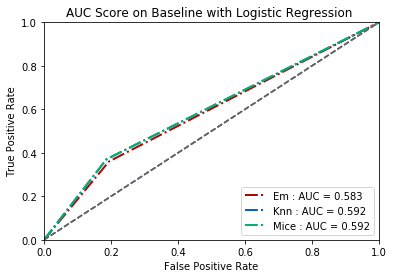

Predicted     0    1
Actual              
0          2207  504
1            63   37

[0.         0.18590926 1.        ] [0.   0.37 1.  ]


In [27]:

colors = ['#b00404','#0462b0','#04b06b']
linestyles = ['-.','-.','-.']
for key, color,lstyle in zip(os_dfs_dict,colors,linestyles):
    print(key)
    # Iterating thorugh all periods
    best_period = os_dfs_dict[key][0]

    X = best_period.iloc[:,0:-1].values
    y = best_period["outcome"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)
    
#     log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)
    log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 42, solver = 'saga' )

    log_reg_classifier.fit(X_train, y_train)
    y_pred_dt = log_reg_classifier.predict(X_test)
    
    log_score = []
    log_score.append(log_reg_classifier.score(X_test,y_test))

    fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred_dt, average='binary')
    print('Precision is: {0:.3f}'.format(precision))
    recall = recall_score(y_test, y_pred_dt, average='binary')
    print('Recall is: {0:.3f}'.format(recall))
    f1 = f1_score(y_test, y_pred_dt, average='binary')
    print('F1-Score is: {0:.3f}'.format(f1))
    print()
    confusion_matrix = pd.crosstab(y_test, y_pred_dt, rownames=['Actual'], colnames=['Predicted'])
    print (confusion_matrix)
    print()
    print(fpr, tpr)

    plt.title('AUC Score on Baseline with Logistic Regression ')
    plt.plot(fpr, tpr, color=color,linestyle=lstyle,lw = 2 ,label = '{0} : AUC = {1:.3f}'.format(key, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--',color='#67636e')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    fileName = '/Users/ishan/Documents/uoe/dissertation/FinalBaseline.eps'.format(key)
    plt.savefig(fileName)
plt.show()
# cm = confusion_matrix(y_test, y_pred_dt)
# print(cm)
confusion_matrix = pd.crosstab(y_test, y_pred_dt, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
print()
print(fpr, tpr)
# sns.heatmap(confusion_matrix, annot=True)
# plt.show()
# confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
# print (confusion_matrix)
# print()
# print(fpr, tpr)

# DT

Imputation: Em
Precision is: 0.727
Recall is: 0.784
F1-Score is: 0.755
Imputation: Knn
Precision is: 0.702
Recall is: 0.784
F1-Score is: 0.741
Imputation: Mice
Precision is: 0.726
Recall is: 0.755
F1-Score is: 0.740


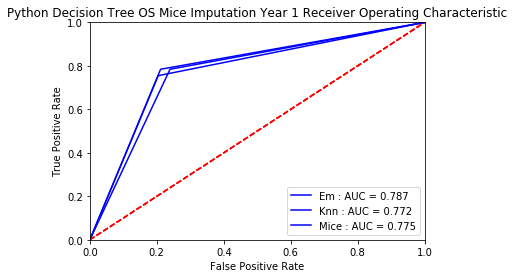

In [15]:

# best_period = os_dfs_dict["Mean"][0]
# best_period
# os_dfs_dict.keys()
for key in os_dfs_dict:
    print("Imputation:",key)
    # Iterating thorugh all periods
    best_period = os_dfs_dict[key][0]

    X = best_period.iloc[:,0:-1].values
    y = best_period["outcome"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

    decision_tree_classifier_roc = DecisionTreeClassifier(random_state=42)
    decision_tree_classifier_roc.fit(X_train, y_train)
    y_pred_dt = decision_tree_classifier_roc.predict(X_test)
    

    fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred_dt, average='binary')
    print('Precision is: {0:.3f}'.format(precision))
    recall = recall_score(y_test, y_pred_dt, average='binary')
    print('Recall is: {0:.3f}'.format(recall))
    f1 = f1_score(y_test, y_pred_dt, average='binary')
    print('F1-Score is: {0:.3f}'.format(f1))
    plt.title('Python Decision Tree OS {0} Imputation Year 1 Receiver Operating Characteristic'.format(key))
    
    plt.plot(fpr, tpr, 'b', label = '{0} : AUC = {1:.3f}'.format(key, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()
    
#     cm = confusion_matrix(y_test, y_pred_dt)
#     f1 = f1_score(y_test, y_pred_dt, average='binary')
#     print('F1-Score is: {0:.3f}'.format(f1))
#     print()
#     sns.set(font_scale=1) # for label size
#     sns.heatmap(cm,annot=True)
#     plt.show()
    

# RF

Em
Precision is: 0.710
Recall is: 0.647
F1-Score is: 0.677
Knn
Precision is: 0.710
Recall is: 0.647
F1-Score is: 0.677
Mice
Precision is: 0.707
Recall is: 0.686
F1-Score is: 0.697


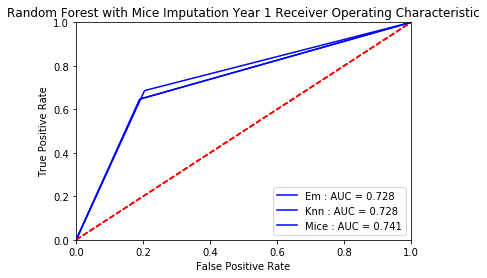

In [16]:
for key in os_dfs_dict:
    print(key)
    # Iterating thorugh all periods
    best_period = os_dfs_dict[key][0]

    X = best_period.iloc[:,0:-1].values
    y = best_period["outcome"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)
    
    random_forest_classifier_sklearn_roc = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

    random_forest_classifier_sklearn_roc.fit(X_train, y_train)
    y_pred_dt = random_forest_classifier_sklearn_roc.predict(X_test)

    fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred_dt, average='binary')
    print('Precision is: {0:.3f}'.format(precision))
    recall = recall_score(y_test, y_pred_dt, average='binary')
    print('Recall is: {0:.3f}'.format(recall))
    f1 = f1_score(y_test, y_pred_dt, average='binary')
    print('F1-Score is: {0:.3f}'.format(f1))
    
    plt.title('Random Forest with {0} Imputation Year 1 Receiver Operating Characteristic'.format(key))
    

#     plt.title('Sklearn  OS Mean Imputation Year 1 Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = '{0} : AUC = {1:.3f}'.format(key, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()
#     f1 = f1_score(y_test, y_pred_dt, average='binary')
#     print('F1-Score is: {0:.3f}'.format(f1))
#     cm = confusion_matrix(y_test, y_pred_dt)
#     print(cm)

    

# XGBoost

Em
Precision is: 0.881
Recall is: 0.370
F1-Score is: 0.521
Knn
Precision is: 0.933
Recall is: 0.420
F1-Score is: 0.579
Mice
Precision is: 0.945
Recall is: 0.520
F1-Score is: 0.671


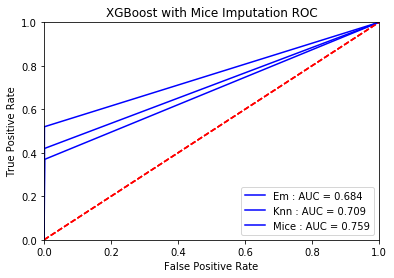

In [31]:
# log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)

for key in os_dfs_dict:
    print(key)
    # Iterating thorugh all periods
    best_period = os_dfs_dict[key][0]

    X = best_period.iloc[:,0:-1].values
    y = best_period["outcome"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)
    
#     log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)
    xgb_classifier = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.2,  
                      colsample_bytree = 0.4,
                      subsample = 1.0,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=9, 
                      gamma=0)

    xgb_classifier.fit(X_train, y_train)
    y_pred_dt = xgb_classifier.predict(X_test)

    fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred_dt, average='binary')
    print('Precision is: {0:.3f}'.format(precision))
    recall = recall_score(y_test, y_pred_dt, average='binary')
    print('Recall is: {0:.3f}'.format(recall))
    f1 = f1_score(y_test, y_pred_dt, average='binary')
    print('F1-Score is: {0:.3f}'.format(f1))

    plt.title('XGBoost with {0} Imputation ROC'.format(key))
    plt.plot(fpr, tpr, 'b', label = '{0} : AUC = {1:.3f}'.format(key, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    fileName = '/Users/ishan/Documents/uoe/dissertation/Polish-Bankruptcy-Prediction/src/imgs/Yr1_XGB_ROC_{0}.eps'.format(key)
#     plt.savefig(fileName)
plt.show()
    
#     print(cm)
    

# Bagging

Em
Precision is: 0.683
Recall is: 0.804
F1-Score is: 0.739
Knn
Precision is: 0.766
Recall is: 0.833
F1-Score is: 0.798
Mice
Precision is: 0.714
Recall is: 0.833
F1-Score is: 0.769


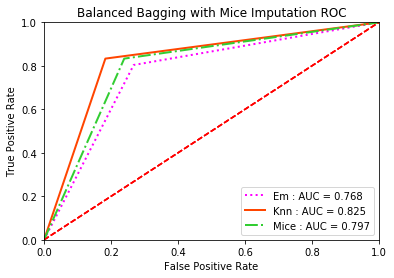

In [18]:
# log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)
colors = ['magenta','orangered','limegreen']
linestyles = [':','-','-.']
for key, color,lstyle in zip(os_dfs_dict,colors,linestyles):
    print(key)
    # Iterating thorugh all periods
    best_period = os_dfs_dict[key][0]

    X = best_period.iloc[:,0:-1].values
    y = best_period["outcome"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)
    
#     log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)
    bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), 
                                          n_estimators = 10, 
                                          bootstrap = True)


    bb_classifier.fit(X_train, y_train)
    y_pred_dt = bb_classifier.predict(X_test)
    bb_score = []
    bb_score.append(bb_classifier.score(X_test,y_test))
    fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
    roc_auc = auc(fpr, tpr)
    
    precision = precision_score(y_test, y_pred_dt, average='binary')
    print('Precision is: {0:.3f}'.format(precision))
    recall = recall_score(y_test, y_pred_dt, average='binary')
    print('Recall is: {0:.3f}'.format(recall))
    f1 = f1_score(y_test, y_pred_dt, average='binary')
    print('F1-Score is: {0:.3f}'.format(f1))

    plt.title('Balanced Bagging with {0} Imputation ROC'.format(key))
    plt.plot(fpr, tpr, color=color,linestyle=lstyle,lw = 2 ,label = '{0} : AUC = {1:.3f}'.format(key, roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    fileName = '/Users/ishan/Documents/uoe/dissertation/Polish-Bankruptcy-Prediction/src/imgs/Yr1_BB_ROC_{0}.eps'.format(key)
#     plt.savefig(fileName)
plt.show()
#     cm = confusion_matrix(y_test, y_pred_dt)
#     print(cm)
    

In [ ]:
# for key in os_dfs_dict:
#     print(key)
#     # Iterating thorugh all periods
#     best_period = os_dfs_dict[key][0]

#     X = best_period.iloc[:,0:-1].values
#     y = best_period["outcome"].values

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)
    
#     random_forest_classifier_sklearn_roc = RandomForestClassifier(criterion="gini", 
#                                                           n_estimators = 50,
#                                                           max_features = "sqrt", 
#                                                           random_state = 94)

#     random_forest_classifier_sklearn_roc.fit(X_train, y_train)
#     y_pred_dt = random_forest_classifier_sklearn_roc.predict(X_test)
#     rfc_score=[]
#     rfc_score.append(random_forest_classifier_sklearn_roc.score(X_test,y_test))

#     fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
#     roc_auc = auc(fpr, tpr)

#     plt.title('Sklearn Random Forest OS Mean Imputation Year 1 Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = '{0} : AUC = {1:.2f}'.format(key, roc_auc))
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
# plt.show()
# #     cm = confusion_matrix(y_test, y_pred_dt)
# #     print(cm)
# #     print(random_forest_classifier_sklearn_roc.score(X_test,y_test))
    

In [ ]:

# resultsDf = show_results(parsed_results_sklearn)
# print(5)
# # resultsDf.head()

resultsDf = (rank_model_sklearn_df[rank_model_sklearn_df.columns[:]])

In [ ]:
type(resultsDf)

In [ ]:
resultsDf.to_excel("compareResults.xlsx") 

In [ ]:
resultsDf

In [ ]:
#Compute the difference between the results
diff = [y - x for y, x in zip(rfc_score, bb_score)]
#Comopute the mean of differences
d_bar = np.mean(diff)
#compute the variance of differences
sigma2 = np.var(diff)
#compute the number of data points used for training 
n1 = len(y_train)
#compute the number of data points used for testing 
n2 = len(y_test)
#compute the total number of data points
n = len(y)
#compute the modified variance
sigma2_mod = sigma2 * (1/n + n2/n1)
#compute the t_static
t_static =  d_bar / np.sqrt(sigma2_mod)
from scipy.stats import t
#Compute p-value and plot the results 
Pvalue = ((1 - t.cdf(t_static, n-1))*200)
Pvalue

In [ ]:
bb_score

In [ ]:
from scipy import stats

In [ ]:
stats.wilcoxon(bb_score, log_score)

In [ ]:
from numpy.random import randint
from scipy.stats import ks_2samp
# generate results

value, pvalue = ks_2samp(log_score, log_score)
print(value, pvalue)
if pvalue > 0.05:
	print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
	print('Samples are likely drawn from different distributions (reject H0)')

In [ ]:
ttest=stats.ttest_ind(bb_score, rfc_score)
print('t-test independent', ttest)

In [ ]:
t, p = stats.ttest_ind(bb_score, rfc_score, equal_var=True)

In [ ]:
p

In [ ]:
bb_score, rfc_score

In [ ]:
log_score

In [ ]:

# colors = ['#b00404','#0462b0','#04b06b']
# linestyles = ['-.','-.','-.']
# for color,lstyle in zip(colors,linestyles):
# #     print(key)
#     # Iterating thorugh all periods
best_period = dataframes[0].dropna()

X = best_period.iloc[:,0:-1].values
y = best_period["outcome"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

#     log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)
xgb_classifier = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=100, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

decision_tree_classifier_roc = DecisionTreeClassifier(random_state=42)
decision_tree_classifier_roc.fit(X_train, y_train)
y_pred_dt = decision_tree_classifier_roc.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test, y_pred_dt, average='binary')
print('Precision is: {0:.3f}'.format(precision))
recall = recall_score(y_test, y_pred_dt, average='binary')
print('Recall is: {0:.3f}'.format(recall))
f1 = f1_score(y_test, y_pred_dt, average='binary')
print('F1-Score is: {0:.3f}'.format(f1))

plt.title('AUC Score on Baseline with Logistic Regression ')
plt.plot(fpr, tpr, color=color,linestyle=lstyle,lw = 2 ,label = '{0} : AUC = {1:.3f}'.format('hi', roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--',color='#67636e')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#     fileName = '/Users/ishan/Documents/uoe/dissertation/FinalBaseline.eps'.format(key)
#     plt.savefig(fileName)
plt.show()
#     cm = confusion_matrix(y_test, y_pred_dt)
#     print(cm)



In [ ]:
log_reg_classifier.score(X_test,y_test)

In [ ]:
log_reg_classifier.predict(X_test)

In [ ]:
log_reg_classifier= LogisticRegression(penalty = 'l2', random_state = 0)

log_reg_classifier.fit(X_train, y_train)
y_pred_dt = log_reg_classifier.predict(X_test)

In [ ]:
y_pred_dt

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

In [ ]:
fpr, tpr